In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
from src.data_processing.dataset import iScatDataset
from src.data_processing.utils import Utils
import torch
import numpy as np
import matplotlib.pyplot as plt
DEVICE= 'cuda:7' if torch.cuda.is_available() else 'cpu'
data_path_1 = os.path.join('dataset', '2024_11_11', 'Metasurface', 'Chip_02')
data_path_2 = os.path.join('dataset', '2024_11_12', 'Metasurface', 'Chip_01')
image_paths= []
target_paths=[]
image_indicies = 12
for data_path in [data_path_1,data_path_2]:
    i,t = Utils.get_data_paths(data_path,'Brightfield',image_indicies )
    image_paths.extend(i)
    target_paths.extend(t)

In [3]:
image_size=256
fluo_masks_indices=[0,1]
seg_method = "comdet"
normalize=False
train_dataset = iScatDataset(image_paths[:-2], target_paths[:-2], preload_image=True,image_size = (image_size,image_size),apply_augmentation=True,normalize=normalize,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method=seg_method)
valid_dataset = iScatDataset(image_paths[-2:],target_paths[-2:],preload_image=True,image_size = (image_size,image_size),apply_augmentation=False,normalize=normalize,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method=seg_method)

Loading images to Memory: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.64it/s]


In [4]:
MEAN = train_dataset.images.mean(dim=(0,2,3),keepdim=True)
STD = train_dataset.images.std(dim=(0,2,3),keepdim=True)
del train_dataset

In [63]:
n_samples = 10
samples = [valid_dataset[i] for i in range(n_samples)]

In [6]:
experiments_paths = (
    'experiments/runs/UNet_Brightfield_2025-01-12_18-05-44',
    'experiments/runs/UNet_Brightfield_2025-01-12_19-09-15',
    'experiments/runs/UNet_Brightfield_2025-01-12_20-27-14')
 

In [88]:
torch.load(experiments_paths[1]+'/best_model.pth',weights_only=False)['val_miou']

0.6970430868012565

In [7]:
from src.models.Unet import UNet
def load_model(path, num_classes=2,device=DEVICE):
    model = UNet(in_channels=12, num_classes=num_classes, init_features=64)
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  
    return model
    
def predict(model, image, mean, std, device):
    model.eval()
    input_image = image.to(device).unsqueeze(0) # torch.Size([1, 3, 224, 224])
    input_image = Utils.z_score_normalize(input_image, mean, std)
    with torch.no_grad():
        output = model(input_image)  # Shape: [1, num_classes, 224, 224]
    predicted_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()  # Shape: (224, 224)

    return predicted_mask


In [8]:
def normalize_image(image):
    """
    Normalize a 16-bit grayscale image to 8-bit for visualization.

    Parameters:
        image (ndarray): 16-bit grayscale image.

    Returns:
        ndarray: 8-bit grayscale image.
    """
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    return (image * 255).astype(np.uint8)  # Scale to [0, 255]

def overlay_mask(image, mask, color, alpha=0.5):
    """Overlays a mask on an image with a specified color and transparency."""
    if len(image.shape) == 2:
        overlay = np.stack([image] * 3, axis=-1)
    else:
        overlay = image.copy()
    for c in range(3):
        overlay[:, :, c] = np.where(mask, overlay[:, :, c] * (1 - alpha) + color[c] * alpha, overlay[:, :, c])
    return overlay

def image_with_masks(image, predicted_mask, ground_truth_mask):
    predicted_colors = {
        1: (0, 255, 0),      # Green for class 1
        2: (0, 0, 255),    # Blue for class 2
    }
    gt_colors = {
        1: (255, 0, 0),      # Red for class 1
        2: (255,255, 0),    # Yellow for class 2
    }

    # Normalize image for visualization
    image_normalized = normalize_image(image)
    combined_image = image_normalized.copy()

    # Overlay masks for each class
    for class_label, color in predicted_colors.items():
        class_mask = (predicted_mask == class_label)
        combined_image = overlay_mask(combined_image, class_mask, color=color, alpha=0.5)

    for class_label, color in gt_colors.items():
        class_mask = (ground_truth_mask == class_label)
        combined_image = overlay_mask(combined_image, class_mask, color=color, alpha=0.5)
    return combined_image


In [73]:
sample = samples[3]
preds = []
for idx, path in enumerate(experiments_paths):
    image = sample[0].clone()
    gt_mask = sample[1].clone()
    if idx==2:
        num_classes=3
    else:
        num_classes=2
    model_path = path+'/best_model.pth'
    model = load_model(model_path,num_classes=num_classes)
    pred_mask = predict(model, image, MEAN, STD, DEVICE)
    if idx==0:
        pred_mask[pred_mask==2]=0
        gt_mask[gt_mask==2]=0
        combined_image = image_with_masks(image[0].cpu().numpy(), pred_mask , gt_mask.cpu().numpy())
    elif idx==1:
        pred_mask[pred_mask==1]=1
        gt_mask[gt_mask==1]=0  
        gt_mask[gt_mask==2]=1
        combined_image = image_with_masks(image[0].cpu().numpy(), pred_mask , gt_mask.cpu().numpy())
    else :
        combined_image = []
        for i in range(1,3):
            image = sample[0].clone()
            gt_mask = sample[1].clone()
            pred_mask_ = pred_mask.copy()
            if i==1:
                pred_mask_[pred_mask==2]=0
                gt_mask[gt_mask==2]=0  
            else:
                pred_mask_[pred_mask==1]=0
                gt_mask[gt_mask==1]=0
                pred_mask_[pred_mask==2]=1
                gt_mask[gt_mask==2]=1  
            combined_image_ = image_with_masks(image[0].cpu().numpy(), pred_mask_ , gt_mask.cpu().numpy())
            combined_image.append(combined_image_)
    preds.append(combined_image)
image = normalize_image(image[0].cpu().numpy())

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


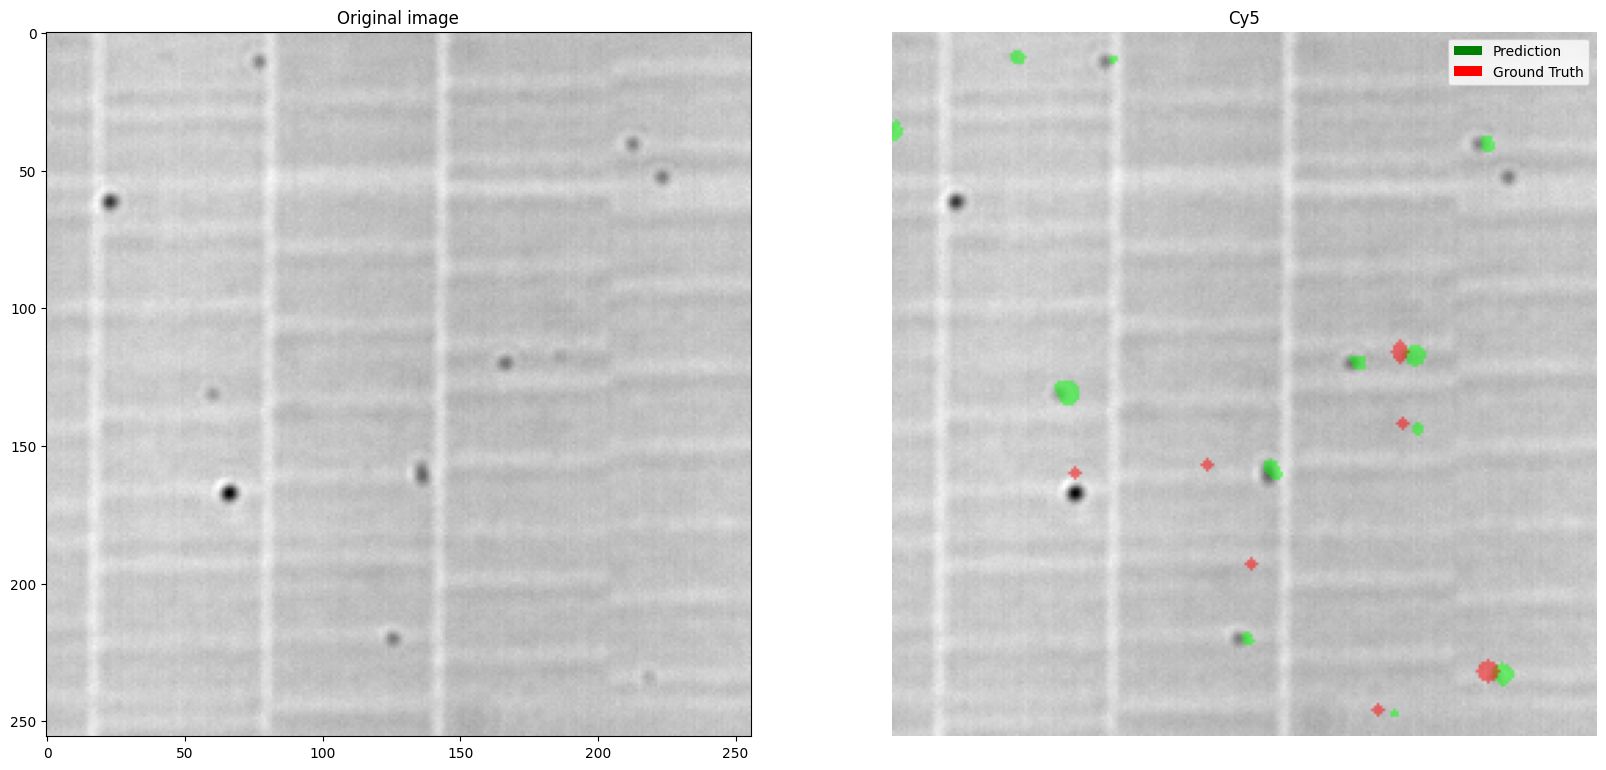

In [75]:
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Prediction'),
    Patch(facecolor='red', label='Ground Truth')
]
fig ,(ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image,cmap="gray")
ax2.imshow(preds[0])
ax2.axis("off")
ax2.set_title("Cy5")
ax1.set_title("Original image")
ax2.legend(handles=legend_elements, loc='upper right')
fig.show()

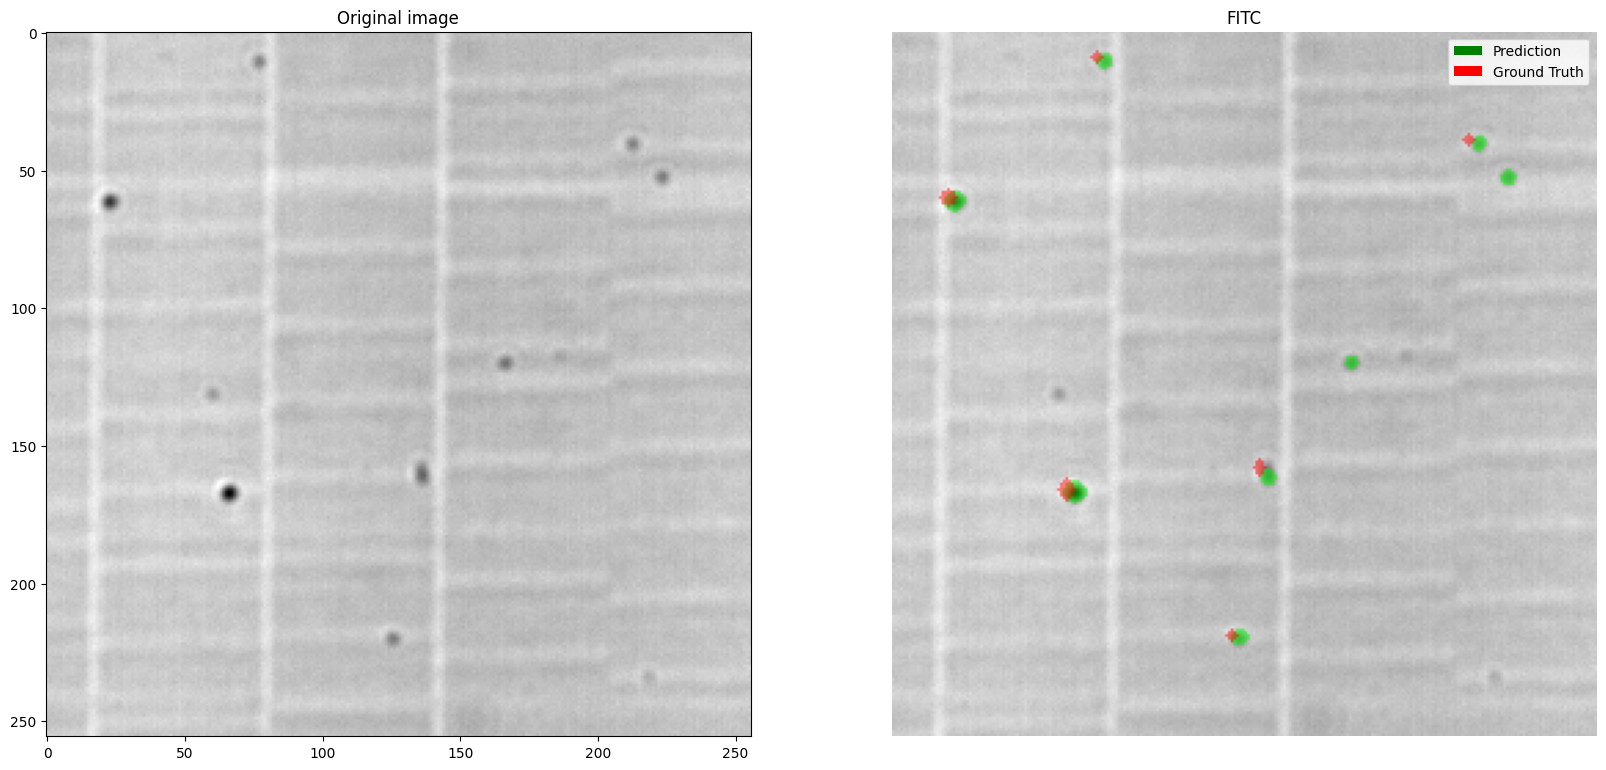

In [76]:
fig ,(ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image,cmap="gray")
ax2.imshow(preds[1])
ax2.axis("off")
ax2.set_title("FITC")
ax1.set_title("Original image")
ax2.legend(handles=legend_elements, loc='upper right')
fig.show()

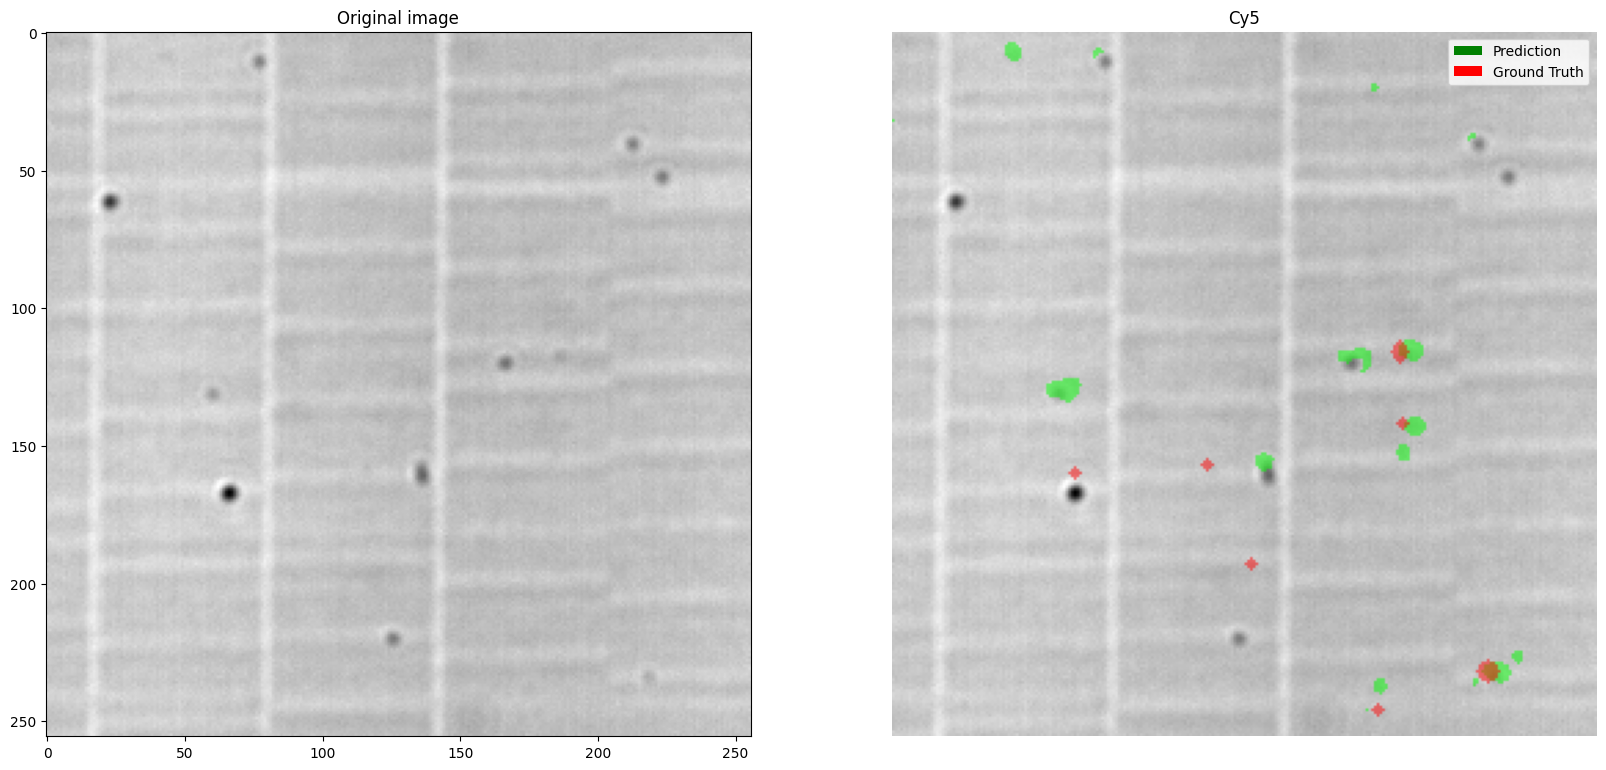

In [77]:
fig ,(ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image,cmap="gray")
ax2.imshow(preds[2][0])
ax2.axis("off")
ax2.set_title("Cy5")
ax1.set_title("Original image")
ax2.legend(handles=legend_elements, loc='upper right')
fig.show()

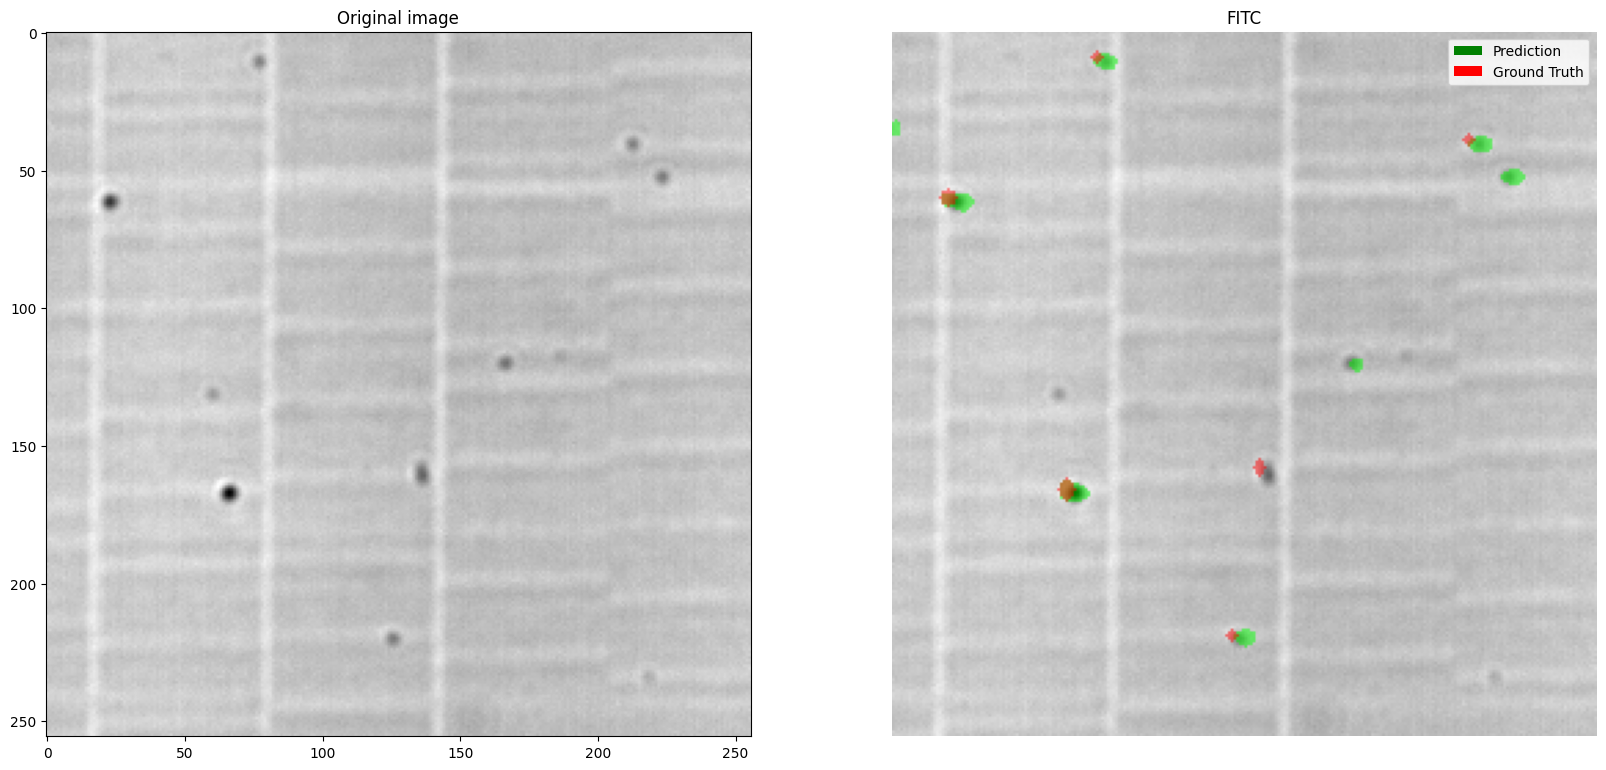

In [78]:
fig ,(ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image,cmap="gray")
ax2.imshow(preds[2][1])
ax2.axis("off")
ax2.set_title("FITC")
ax1.set_title("Original image")
ax2.legend(handles=legend_elements, loc='upper right')
fig.show()

In [48]:
# # Plot the image and the overlays
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# # Original image visualization
# ax1.imshow(preds[0])
# ax1.set_title("Cy5 Model")
# ax1.axis("off")

# # Combined overlay visualization
# ax2.imshow(preds[1])
# ax2.set_title("FITC Model")
# ax2.axis("off")

# ax3.imshow(preds[2])
# ax3.set_title("FITC & Cy5 Model")
# ax3.axis("off") 

# plt.tight_layout()


# predicted_colors = {
#     1: (0, 255, 0),      # Green for class 1
#     2: (0, 0, 255),    # Blue for class 2
# }
# gt_colors = {
#     1: (255, 0, 0),      # Red for class 1
#     2: (255,255, 0),    # Yellow for class 2
# }
# legend_elements = []
# for class_label, color in predicted_colors.items():
#     legend_elements.append(plt.Line2D([0], [0], color=np.array(color) / 255, lw=4, label=f'Predicted Class {class_label}'))
# for class_label, color in gt_colors.items():
#     legend_elements.append(plt.Line2D([0], [0], color=np.array(color) / 255, lw=4, linestyle='dashed', label=f'GT Class {class_label}'))
# fig.legend(handles=legend_elements, loc='lower right', fontsize='small')
# plt.show()